In [108]:
# NOTEBOOK FOR BATCH PROCESSING SEGMENTATION

In [1]:
import numpy as np
import pandas as pd
import tifffile as tf
from cellpose import models
from cellpose import utils
from skimage.measure import label, regionprops
import os
from tqdm import tqdm
from scipy.spatial.distance import cdist
from skimage.segmentation import expand_labels, watershed
import matplotlib.pyplot as plt

In [2]:
path_unsegmented_datasets='../../figures/2.comparison_between_datasets/input_for_segmentation/'
datasets=os.listdir(path_unsegmented_datasets)

In [3]:
ds='Vizgen'

In [6]:
## COSMX DATASET BREAKS TO SEGMENT
## VIZGEN DATASET DOESN'T HAVE A GOOD CORRESPONDANCE TO READS. WE NEED TO APPLY A TRANSFORMATION (MAYBE?)

In [5]:
#########this is the formatting
read_positions = pd.read_csv(path_unsegmented_datasets+ds+'/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_detected_transcripts_S2R3.csv',index_col=0)
read_positions['x']=read_positions['global_x']*9.205861091613769531
read_positions['y']=read_positions['global_y']*9.205861091613769531
read_positions=read_positions.loc[:,['x','y','gene']]
read_positions.to_csv(path_unsegmented_datasets+ds+'/transcripts.csv')


KeyboardInterrupt



In [4]:
# everything is already converted, no need to do it again
read_positions=pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)

In [9]:
dapi_image = tf.imread(path_unsegmented_datasets+ds+'/DAPI.tif')
tile_size=[2000,2000]
overlap=100
tile_positions = []
segmented_masks = []
from tqdm import tqdm

In [ ]:
# Display the final mask (for visualization purposes)
plt.figure(figsize=(10,10))
plt.imshow(dapi_image,vmax=2700)
plt.scatter(read_positions.x,read_positions.y,s=0.001,c='red')

In [ ]:
height, width = dapi_image.shape[:2]

for y in tqdm(range(0, height, tile_size[1] - overlap)):
    for x in tqdm(range(0, width, tile_size[0] - overlap)):
        # Calculate tile boundaries
        x1, x2 = x, min(x + tile_size[0], width)
        y1, y2 = y, min(y + tile_size[1], height)

        # Extract the tile
        tile = dapi_image[y1:y2, x1:x2]

        # Store the tile position
        tile_positions.append((x1, y1))

        # Step 2: Segment each tile with Cellpose
        # Initialize Cellpose model
        model = models.Cellpose(gpu=False)  # You can set GPU to True if available

        # Run Cellpose on each tile
        masks, _, _, _ = model.eval(tile, channels=[0, 0], diameter=None)  # Modify channels and diameter as needed
        
        segmented_masks.append(masks)

  0%|                                                                                            | 0/49 [00:00<?, ?it/s]/home/sergio/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sergio/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 10%|████████▎                                                                         | 5/49 [06:50<1:05:45, 89.66s/it]

In [ ]:
# Step 3: Recompose the segmented masks into a single mask
full_mask = np.zeros((height, width), dtype=np.uint8)

for mask, position in tqdm(zip(segmented_masks, tile_positions)):
    x, y = position
    h, w = mask.shape[:2]
    full_mask[y:y + h, x:x + w] = mask # Assuming you want only one channel of the mask

In [17]:
full_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
# Optional: Save the full mask to a file
tf.imwrite(path_unsegmented_datasets+ds+"/segmented_mask.tif", full_mask)

In [12]:
np.max(full_mask)

255

In [ ]:
# Optional: Save the full mask to a file
tf.imwrite(path_unsegmented_datasets+ds+"/segmented_mask.tif", full_mask)

In [4]:
#read_positions = pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)

In [11]:
# Optional: Save the full mask to a file
full_mask=tf.imread(path_unsegmented_datasets+ds+"/segmented_mask.tif")
# everything is already converted, no need to do it again
read_positions=pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)

In [5]:
# this is for xenium
#from tqdm import tqdm
#read_positions['x']=read_positions['x']*4.70588
#read_positions['y']=read_positions['y']*4.70588

In [6]:
#this is for nanostring
#read_positions['x']=read_positions['y_global_px']
#read_positions['y']=read_positions['x_global_px']
#read_positions['x']=np.max(read_positions['x'])-read_positions['x']
#read_positions['y']=np.max(read_positions['y'])-read_positions['y']

In [ ]:
# Display the final mask (for visualization purposes)
plt.figure(figsize=(10,10))
plt.imshow(full_mask,vmax=100)
plt.scatter(read_positions.x,read_positions.y,s=0.00001,c='red')

In [7]:
bin_mask=(full_mask>0)*1
del full_mask

In [8]:
labeled_nuclei = label(bin_mask)

In [9]:
del bin_mask
#del full_mask

In [10]:
tf.imwrite(path_unsegmented_datasets+ds+"/labeled_nuclei.tif", labeled_nuclei)

In [ ]:
tf.imwrite(path_unsegmented_datasets+ds+"/labeled_nuclei.tif", labeled_nuclei)

In [ ]:
from tqdm import tqdm

In [6]:
mid1=labeled_nuclei.shape[0]/3

In [7]:
labeled_nuclei1=labeled_nuclei[:int(mid1),:]

In [8]:
#labeled_nuclei = label(masks)
expanded_nuclei1 = expand_labels(labeled_nuclei1, distance=400)

In [9]:
tf.imwrite(path_unsegmented_datasets+ds+"/expanded_nuclei1.tif", expanded_nuclei1)

In [ ]:
mid2=(labeled_nuclei.shape[0]/3)+(labeled_nuclei.shape[0]/3)

In [12]:
labeled_nuclei2=labeled_nuclei[int(mid1):int(mid2),:]

In [ ]:
#labeled_nuclei = label(masks)
expanded_nuclei2 = expand_labels(labeled_nuclei2, distance=400)

In [ ]:
tf.imwrite(path_unsegmented_datasets+ds+"/expanded_nuclei2.tif", expanded_nuclei2)

In [ ]:
labeled_nuclei3=labeled_nuclei[int(mid2):,:]

In [ ]:
#labeled_nuclei = label(masks)
expanded_nuclei3 = expand_labels(labeled_nuclei3, distance=400)

In [ ]:
tf.imwrite(path_unsegmented_datasets+ds+"/expanded_nuclei3.tif", expanded_nuclei3)

In [6]:
expanded_nuclei3=tf.imread(path_unsegmented_datasets+ds+"/expanded_nuclei3.tif")
expanded_nuclei2=tf.imread(path_unsegmented_datasets+ds+"/expanded_nuclei2.tif")
expanded_nuclei1=tf.imread(path_unsegmented_datasets+ds+"/expanded_nuclei1.tif")

In [7]:
expanded_nuclei12=np.vstack((expanded_nuclei1,expanded_nuclei2))

In [8]:
del expanded_nuclei1
del expanded_nuclei2

In [9]:
expanded_nuclei=np.vstack((expanded_nuclei12,expanded_nuclei3))
del expanded_nuclei3
del expanded_nuclei12

In [10]:
tf.imwrite(path_unsegmented_datasets+ds+"/expanded_nuclei.tif", expanded_nuclei)

In [17]:
expanded_nuclei=tf.imread(path_unsegmented_datasets+ds+"/expanded_nuclei.tif")

In [18]:
labeled_nuclei=tf.imread(path_unsegmented_datasets+ds+"/labeled_nuclei.tif")
read_positions=pd.read_csv(path_unsegmented_datasets+ds+'/transcripts.csv',index_col=0)

In [19]:
read_positions['in_cell']=0
read_positions['closest_cell']=0
centroid_dictx={}
centroid_dicty={}
for nucleus_props in regionprops(labeled_nuclei):
    centroid_dictx[nucleus_props.label]=nucleus_props.centroid[0]
    centroid_dicty[nucleus_props.label]=nucleus_props.centroid[1]
closest_cell=[]
in_cell=[]

In [20]:
print('starting with assignment')
for ind in tqdm(read_positions.index):
    try:
        in_cell.append(labeled_nuclei[int(read_positions.loc[ind,'y']),int(read_positions.loc[ind,'x'])])
        closest_cell.append(expanded_nuclei[int(read_positions.loc[ind,'y']),int(read_positions.loc[ind,'x'])])
    except:
        in_cell.append(0)
        closest_cell.append(0)

starting with assignment


100%|████████████████████████████████████████████████████████████████████| 68716021/68716021 [43:19<00:00, 26435.43it/s]


In [21]:
del labeled_nuclei
del expanded_nuclei

In [22]:
read_positions['in_cell']=in_cell
read_positions['closest_cell']=closest_cell
read_positions['closest_cell_x']=read_positions['closest_cell'].map(centroid_dictx)
read_positions['closest_cell_y']=read_positions['closest_cell'].map(centroid_dicty)
read_positions['distance_to_centroid']=np.sqrt((read_positions['closest_cell_x']-read_positions['y'])**2 +(read_positions['closest_cell_y']-read_positions['x'])**2)
cellxgene=pd.crosstab(read_positions['in_cell'],read_positions['gene'])
cellxgene=cellxgene.loc[~cellxgene.index.isin([0]),:]
read_positions.to_csv(path_unsegmented_datasets+ds+'/transcripts_with_cell_assignment.csv')
import scanpy as sc
adata=sc.AnnData(cellxgene)
adata.obs['x_centroid']=adata.obs.index.astype(int).map(centroid_dictx)
adata.obs['y_centroid']=adata.obs.index.astype(int).map(centroid_dicty)
adata.write(path_unsegmented_datasets+ds+'/adata.h5ad')

/tmp/ipykernel_480094/1592245671.py:10: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata=sc.AnnData(cellxgene)
/home/sergio/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [25]:
read_positions

,x,y,gene,in_cell,closest_cell,closest_cell_x,closest_cell_y,distance_to_centroid
0,912.798926,20638.492940,Mc4r,0,115810,20642.685512,880.671378,32.399954
1,703.914017,21366.091060,Csf1r,0,118339,21330.785714,739.142857,49.875231
2,583.721558,22757.459382,Gpr22,0,123178,22794.066265,556.710843,45.493325
3,1299.980818,24007.155025,Agtr1a,0,127045,24020.344828,1255.637931,46.262972
4,195.099980,25273.608097,Gpr22,0,130615,25243.520958,197.838323,30.211496
...,...,...,...,...,...,...,...,...
68716016,91570.773925,26820.788380,Gpr22,0,134633,26833.000000,91562.000000,15.036803
68716017,90423.999809,25810.685398,Gpr22,0,131982,25834.467532,90471.534323,53.151857
68716018,92127.166964,25831.504453,Gpr22,0,132014,25842.860465,92125.406977,11.491587
68716019,92143.958454,25865.916882,Gpr22,0,132014,25842.860465,92125.406977,29.593170


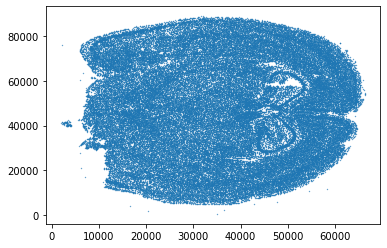

In [23]:
plt.scatter(adata.obs.x_centroid,adata.obs.y_centroid,s=0.1)

In [12]:
sc.pl.spatial(adata,spot_size=400)

KeyError: "Could not find 'spatial' or 'X_spatial' in .obsm"

In [24]:
coords=pd.DataFrame([centroid_dictx.values(),centroid_dicty.values()],columns=centroid_dictx.keys()).transpose()

In [28]:
rp1=read_positions[read_positions['in_cell']==0]

In [31]:
coords.columns=['x','y']

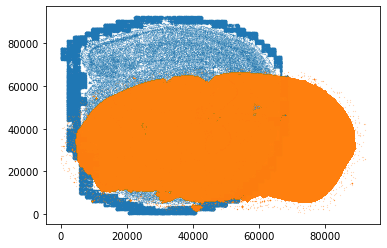

In [33]:
plt.scatter(coords.x,coords.y,s=0.01)
plt.scatter(rp1.x,rp1.y,s=0.01)

In [34]:
from tqdm import tqdm
#['closest_cell']='nan'
print('caclulating distance to vessel...')
for rd in tqdm(rp1.index):
        meas=((coords['x']-rp1.loc[rd,'y'])**2)+((coords['y']-rp1.loc[rd,'x'])**2)
        rp1.loc[rd,'closest_cell']=meas.idxmin()

caclulating distance to vessel...


  0%|                                                                        | 43/62366216 [00:18<7570:14:43,  2.29it/s]

KeyboardInterrupt



In [13]:

        
        
dican=dict(zip(annotatedcells.obs.index,annotatedcells.obs['region_annotation']))
nancells.obs['new_domain']=nancells.obs['new_domain'].map(dican)
new_assignment=dict(zip(nancells.obs.index,nancells.obs['new_domain']))
for indi in nancells.obs.index:
    adatar1.obs.loc[indi,'region_annotation']=new_assignment[indi]

,x,y,gene,in_cell,closest_cell
0,912.798926,20638.492940,Mc4r,0,0
1,703.914017,21366.091060,Csf1r,0,0
2,583.721558,22757.459382,Gpr22,0,0
3,1299.980818,24007.155025,Agtr1a,0,0
4,195.099980,25273.608097,Gpr22,0,0
...,...,...,...,...,...
68716016,91570.773925,26820.788380,Gpr22,0,0
68716017,90423.999809,25810.685398,Gpr22,0,0
68716018,92127.166964,25831.504453,Gpr22,0,0
68716019,92143.958454,25865.916882,Gpr22,0,0


In [14]:
read_positions.to_csv(path_unsegmented_datasets+ds+'/transcripts_with_cell_assignment.csv')

In [ ]:


# Step 2: Segment each tile with Cellpose
segmented_masks = []

# Initialize Cellpose model
model = models.Cellpose(gpu=False)  # You can set GPU to True if available

for tile in tiles:
    # Run Cellpose on each tile
    masks, _, _, _ = model.eval(tile, channels=[0, 0], diameter=30)  # Modify channels and diameter as needed
    segmented_masks.append(masks)

# Step 3: Recompose the segmented masks into a single mask
original_image_shape = large_image.shape[:2]

full_mask = np.zeros(original_image_shape, dtype=np.uint8)

for mask, position in zip(segmented_masks, tile_positions):
    x, y = position
    h, w = mask.shape[:2]
    full_mask[y:y + h, x:x + w] = mask[..., 0]  # Assuming you want only one channel of the mask

# 'full_mask' now contains the segmentation mask for the entire image

# Optional: Save the full mask to a file
cv2.imwrite("segmented_mask.jpg", full_mask)

# Optional: Perform post-processing on the 'full_mask' if needed

# Display the final mask (for visualization purposes)
cv2.imshow("Segmented Mask", full_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import numpy as np

# Assuming 'segmented_masks' is a list of segmented masks for each tile
# and 'tile_positions' is a list of the positions of each tile in the original image

# Determine the shape of the original image
original_image_shape = (height, width)

# Create an empty mask of the same shape as the original image
full_mask = np.zeros(original_image_shape, dtype=np.uint8)

# Iterate through the segmented masks and tile positions
for mask, position in zip(segmented_masks, tile_positions):
    x, y = position  # Position of the top-left corner of the tile
    h, w = mask.shape  # Height and width of the tile
    full_mask[y:y + h, x:x + w] = mask

# 'full_mask' now contains the segmentation mask for the entire image


In [8]:
datasets=['CosMx','Vizgen','Xenium']

In [6]:
for ds in datasets:
    if os.path.exists(path_unsegmented_datasets+ds+'/transcripts_with_cell_assignment.csv'):
        print(ds)
   

HybrISS
MERFISH_ABI
ResolvedBiosciences
